In [2]:
import os
import pathlib
import collections

import pandas as pd
from tqdm.auto import tqdm

import audiocap


tqdm.pandas()

def read_audioset_csv(csv_path, audios_root):
    split_name = pathlib.Path(csv_path).stem
    audios_dir = pathlib.Path(audios_root) / split_name
    df = pd.read_csv(
        csv_path,
        comment='#',
        sep=", ",
        engine='python',
        header=None,
        names=['youtube_id', 'start_seconds', 'end_seconds', 'labels'],
    )
    df = df[df["youtube_id"].apply(lambda x: os.path.exists(audios_dir / f'{x}.mp3'))]
    df["labels"] = df["labels"].str.strip('"').str.split(",")
    df["orig_split"] = split_name
    return df

audio_root = '../data/audioset_full/audios'
df = pd.concat([
    read_audioset_csv('../data/audioset_full/csvs/train_unbalanced.csv', audio_root),
    read_audioset_csv('../data/audioset_full/csvs/train_balanced.csv', audio_root),
    read_audioset_csv('../data/audioset_full/csvs/eval.csv', audio_root),
])
df.drop_duplicates(subset=["youtube_id"], inplace=True)
df.reset_index(drop=True, inplace=True)

len(df)

1770026

In [3]:
df.columns

Index(['youtube_id', 'start_seconds', 'end_seconds', 'labels', 'orig_split'], dtype='object')

In [4]:
ontology = audiocap.audioset_tools.AudiosetOntology.from_json_file('../data/audioset_full/csvs/ontology.json')

In [5]:
label_counts = (
    df["labels"]
    .explode()
    .map(ontology.df["name"].to_dict())
    .value_counts()
    .rename("count")
)

In [6]:
ontology.df[ontology.df.name.str.contains("Whip")]

name                                        description  \
id                                                                    
/m/07rbp7_  Whip  The sound of whipping, i.e., the greatly accel...   

                                                 citation_uri  \
id                                                              
/m/07rbp7_  http://wordnetweb.princeton.edu/perl/webwn?s=whip   

                                            positive_examples child_ids  \
id                                                                        
/m/07rbp7_  [youtu.be/LhbzdtNRTKs?start=30&end=40, youtu.b...        []   

           restrictions  
id                       
/m/07rbp7_           []

In [7]:
ontology.audioset_label_ids_to_str("/m/012n7d, /g/11b630rrvh")

'emergency vehicle, siren, ambulance (siren), domestic sounds - home sounds, whistle, kettle whistle'

In [8]:
audiocap.metrics.keyword_metrics_batch(
    y_pred = ["hello, darkness, my old friend", "a, b, c, d, e"],
    y_true = ["hello, world,", "a, b, c, d"],
)

{'keywords_num_generated': 4.0,
 'keywords_num_true': 3.0,
 'keywords_precision': 0.5666666666666667,
 'keywords_recall': 0.75,
 'keywords_f1': 0.6444444444444445,
 'keywords_jaccard': 0.525}

In [9]:
df["labels"].explode().isin(ontology.df.index).all()

True

In [10]:
pd.options.plotting.backend = "plotly"

In [11]:
len(df["labels"].explode().value_counts())

527

In [12]:
(df["labels"].explode().value_counts() > 400).mean()

0.8292220113851992

In [13]:
music_overrepresented_general = {
    "Musical instrument",
    "Music genre",
}

desired_num_samples_per_class = {label: 500 for label in ontology.df.index}
for category in music_overrepresented_general:
    descendants = ontology.all_descendants(name=category, include_self=True)
    for label in descendants.index:
        desired_num_samples_per_class[label] = 80

pd.Series(desired_num_samples_per_class).value_counts()

500    474
80     158
dtype: int64

In [14]:
selector = audiocap.audioset_tools.AudiosetSubsetSelector(
    df=df,
    desired_num_samples_per_class=desired_num_samples_per_class,
    seed=42,
    step=100,
    ontology=ontology,
)

In [15]:
subset = selector.select_reasonable_subset()
len(subset)

  0%|          | 0/186875 [00:00<?, ?it/s]

134002

In [16]:
def label_word_freqs(*, labels_str=None, label_ids=None):
    freqs = collections.Counter()
    if labels_str is None:
        labels_str = map(ontology.audioset_label_ids_to_str, label_ids)
        length = len(label_ids)
    else:
        length = len(labels_str)
        
    for label_str in tqdm(labels_str, desc="label word frequencies", total=length):
        label_str = "".join([c if c.isalnum() else " " for c in label_str.lower()])
        freqs.update(label_str.split())
    return freqs

In [17]:
subset.sample(30, random_state=42)["labels"].apply(ontology.audioset_label_ids_to_str, include_parents=True).tolist()

['boat - water vehicle, motorboat - speedboat, sounds of things, vehicle',
 'background noise, environmental noise',
 'rail transport, railroad car - train wagon, train, train whistle, vehicle, sounds of things, train wheels squealing',
 'domestic sounds - home sounds, bathtub (filling or washing), acoustic environment, inside - large room or hall',
 'human group actions, noise, hubbub - speech noise - speech babble, human voice, speech, acoustic environment, outside - urban or manmade',
 'bird, crow, caw, human voice, speech, animal',
 'rail transport, railroad car - train wagon, vehicle, train, sounds of things, train wheels squealing',
 'domestic sounds - home sounds, bathtub (filling or washing)',
 'vehicle horn - car horn - honking, toot',
 'human group actions, noise, hubbub - speech noise - speech babble, human voice, speech',
 'human voice, singing, country, swing music',
 'fowl, goose',
 'onomatopoeia, rustle',
 'human locomotion, run, acoustic environment, outside - rural or 

In [18]:
import wordcloud 

freqs = label_word_freqs(label_ids=subset["labels"])

label word frequencies:   0%|          | 0/134002 [00:00<?, ?it/s]

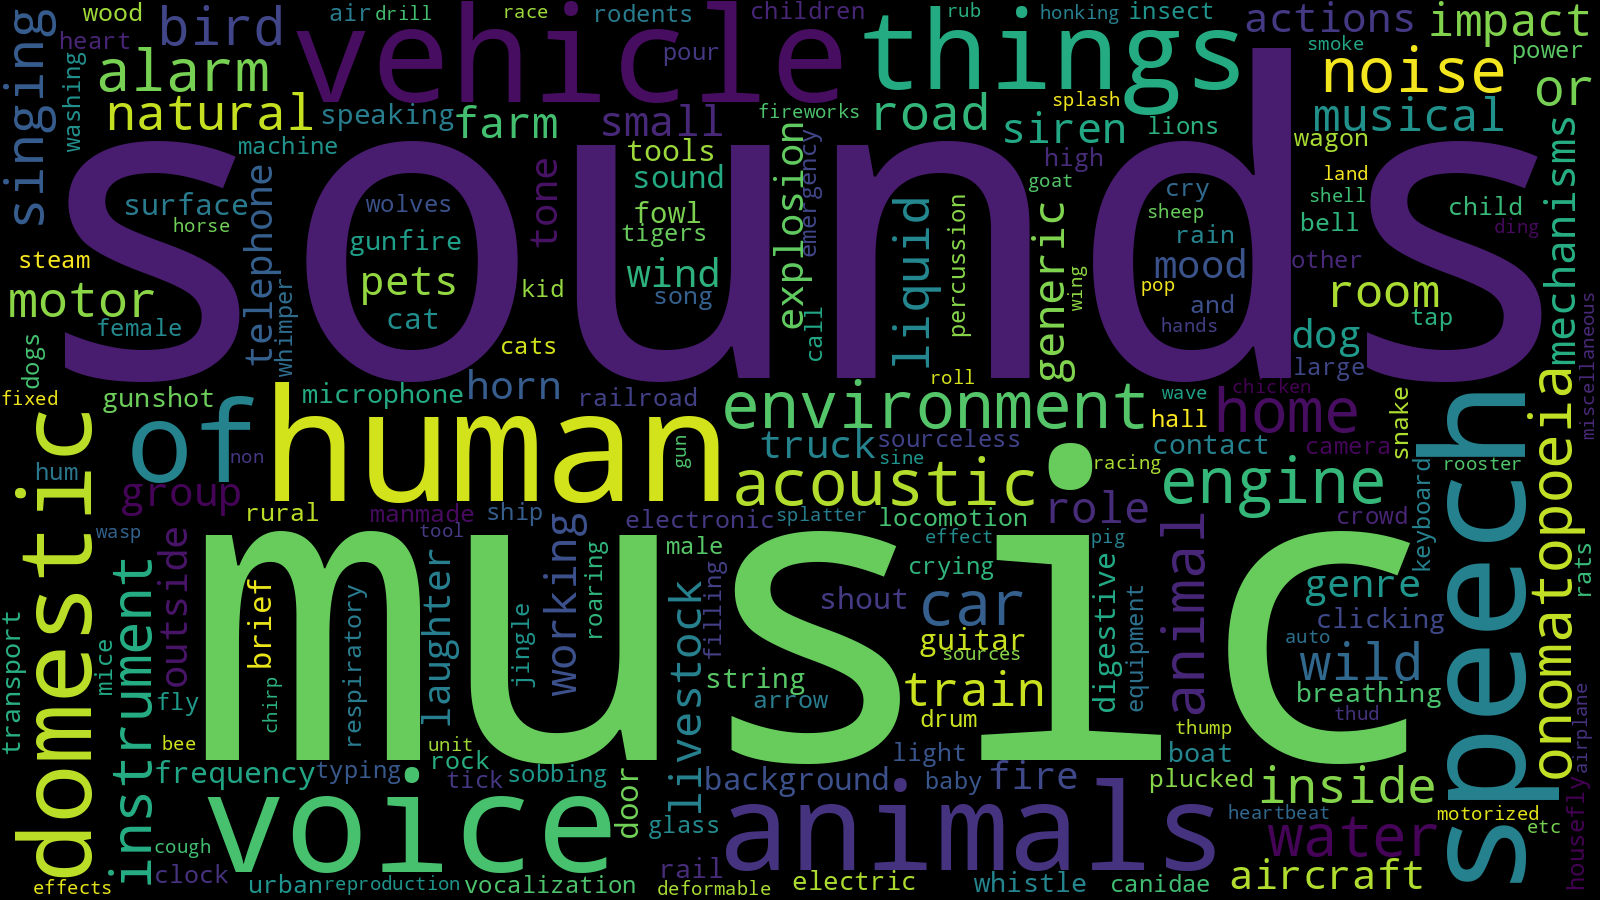

In [19]:
wordcloud.WordCloud(width=1600, height=900).generate_from_frequencies(freqs).to_image()

In [20]:
import numpy as np
import scipy.stats
import plotly.express

def print_subset_info(
    df_all: pd.DataFrame,
    subset: pd.DataFrame,
    ontology: audiocap.audioset_tools.AudiosetOntology,
    show_histogram: bool = True,
) -> None:
    total_counts = df_all["labels"].explode().value_counts()
    value_counts = subset["labels"].explode().value_counts()
    value_counts.index = value_counts.index.map(ontology.df["name"])
    entropy = scipy.stats.entropy(value_counts / value_counts.sum())
    print(f"Number of covered labels: {len(value_counts)} / total {len(total_counts)}")
    print(f"Entropy: {entropy:.4f}. Max entropy: {np.log(len(total_counts)):.4f}")
    print(f"Number of examples: {len(subset)}")
    value_counts.plot(kind="bar", title="Label Distribution").update_xaxes(tickangle=45).update_layout(showlegend=False).show()
    # create histogram of label counts
    if show_histogram:
        nbins = max(value_counts)//100+1
        plotly.express.histogram(value_counts, title="Label counts histogram", nbins=nbins).update_layout(showlegend=False).show()

In [21]:
print_subset_info(df, subset, ontology)

Number of covered labels: 527 / total 527
Entropy: 5.5940. Max entropy: 6.2672
Number of examples: 134002


In [22]:
value_counts = subset["labels"].explode().value_counts()
# Check how many examples consist only of labels that are represented a lot
subset["labels"].sample(10000, random_state=0).apply(lambda labels: all(value_counts[label] > 700 for label in labels)).mean()

0.0086

In [23]:
labels_str_sample = (
    subset["labels"]
    .sample(20000, random_state=0)
    .apply(ontology.audioset_label_ids_to_str, include_parents=True)
)

In [24]:
labels_str_sample.str.contains("speech").mean()

0.1693

In [25]:
labels_str_sample.str.contains("music").mean()

0.1875

In [26]:
labels_str_sample.str.contains(r"(music)|(speech)", regex=True).mean()

/tmp/ipykernel_1536749/28047695.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



0.3385

In [27]:
audiocaps_train = pd.read_csv("../data/audioCaps/csvs/train.csv")
audiocaps_valid = pd.read_csv("../data/audioCaps/csvs/valid.csv")
audiocaps_test = pd.read_csv("../data/audioCaps/csvs/test.csv")

In [ ]:
audiocaps_train["youtube_id"]

In [32]:
subset.reset_index(inplace=True)

In [34]:
train_subset, test_subset = audiocap.audioset_tools.balanced_split(
    subset,
    must_be_in_train=(set(audiocaps_train["youtube_id"]) | set(audiocaps_valid["youtube_id"])) & set(subset["youtube_id"]),
    must_be_in_test=(set(audiocaps_test["youtube_id"]) & set(subset["youtube_id"])),
    minimum_test_examples_per_class=5,
    seed=9
)

train_subset, valid_subset = audiocap.audioset_tools.balanced_split(
    train_subset,
    must_be_in_train=set(audiocaps_train["youtube_id"]) & set(subset["youtube_id"]),
    must_be_in_test=set(audiocaps_valid["youtube_id"]) & set(subset["youtube_id"]),
    minimum_test_examples_per_class=5,
    seed=5
)

In [35]:
assert train_subset["youtube_id"].is_unique
assert valid_subset["youtube_id"].is_unique
assert test_subset["youtube_id"].is_unique

assert len(train_subset) + len(valid_subset) + len(test_subset) == len(subset)
assert train_subset["youtube_id"].isin(valid_subset["youtube_id"]).sum() == 0
assert train_subset["youtube_id"].isin(test_subset["youtube_id"]).sum() == 0
assert valid_subset["youtube_id"].isin(test_subset["youtube_id"]).sum() == 0


In [36]:
len(train_subset), len(valid_subset), len(test_subset)

(128433, 2726, 2843)

In [38]:
print_subset_info(df, test_subset, ontology, show_histogram=False)

Number of covered labels: 527 / total 527
Entropy: 5.7244. Max entropy: 6.2672
Number of examples: 2843


In [39]:
print_subset_info(df, valid_subset, ontology, show_histogram=False)

Number of covered labels: 527 / total 527
Entropy: 5.7169. Max entropy: 6.2672
Number of examples: 2726


In [40]:
train_subset.columns

Index(['youtube_id', 'level_0', 'index', 'start_seconds', 'end_seconds',
       'labels', 'orig_split', 'selected', 'contains_music', 'contains_speech',
       'contains_no_music_or_speech', 'contains_music_xor_speech',
       'contains_music_and_speech'],
      dtype='object')

In [44]:
export_columns = ["youtube_id", "start_seconds", "end_seconds", "labels", "orig_split"]
train_subset[export_columns].to_json("train.jsonl", orient="records", lines=True, force_ascii=False)
valid_subset[export_columns].to_json("valid.jsonl", orient="records", lines=True, force_ascii=False)
test_subset[export_columns].to_json("test.jsonl", orient="records", lines=True, force_ascii=False)

In [ ]:
# these files were put in the data/audioset_small/annotaitons folder and committed to the repo
# now, they can be used to create the audiofolder